('Corrected gqrs detected peak indices:', [790, 1155, 1492, 1821, 2889, 3237, 3592, 3925, 4103, 4603, 4971, 5348, 5715, 6114, 6478, 6884, 7286, 7686, 8057, 8432, 8804, 9195, 9585, 9962, 10325, 10695, 10875, 11454, 11819, 12174, 12510, 12856, 13237, 13644, 14072, 14467, 14847, 15223, 15620, 16016, 16403, 16789, 17160, 17534, 17932, 18327, 18685, 19044, 19418, 19801, 20193, 20586, 20941, 21306, 21677, 22055, 22427, 22794, 23189, 23610, 24037, 24454, 24850, 25233, 25616, 25991, 26386, 26787, 27180, 27544, 27926, 28313, 28717, 29099, 29454, 29795, 30149, 30546, 30976, 31420, 31856, 32262, 32698, 33121, 33513, 33887, 34259, 34623, 35018, 35413, 35764, 36114, 36473, 36848, 37294, 37780, 38198, 38590, 38990, 39388, 39779])


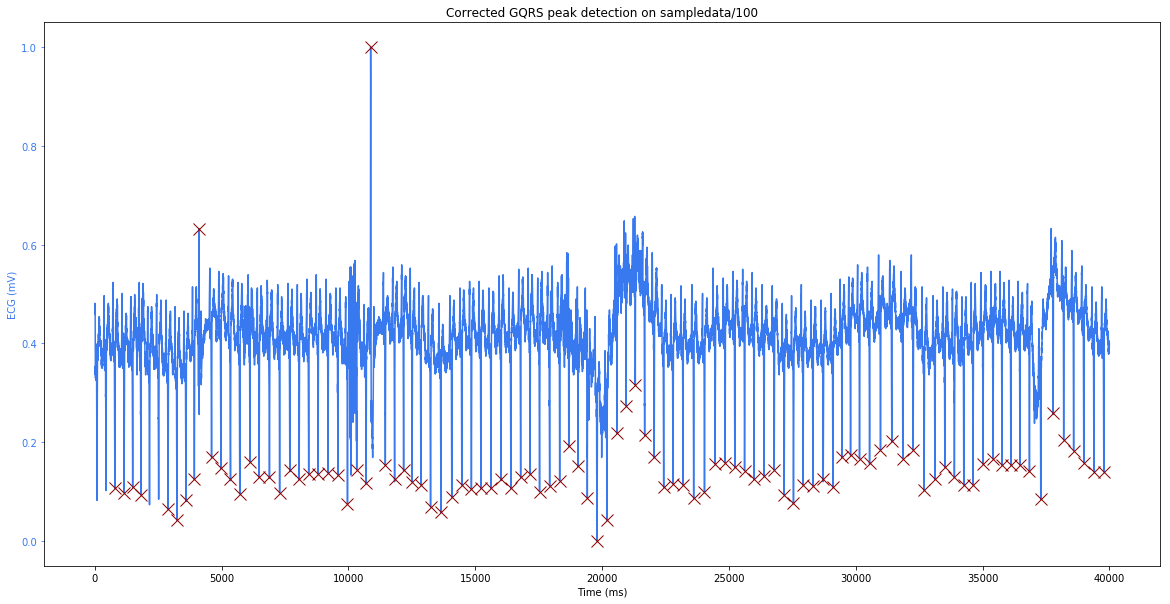

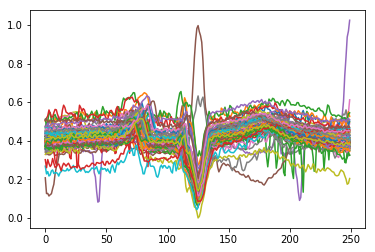

In [3]:
import caffe
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from itertools import tee, izip
import math

#heart rate calculation 
def peaks(x, peak_indices, fs, title, figsize=(20, 10), saveto=None):
    
    # Calculate heart rate
    hrs = wfdb.processing.compute_hr(siglen=x.shape[0], peak_indices=peak_indices, fs=fs)
    fig, ax_left = plt.subplots(figsize=figsize)
    
    ax_left.plot(x, color='#3979f0', label='Signal')
    ax_left.plot(peak_indices, x[peak_indices], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
    
    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_left.tick_params('y', colors='#3979f0')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()
    return hrs

# Single beats extraction for record
def extract_beats(record,R_indices,peaks_hr):
    
    flat_record = [item for sublist in record for item in sublist]
    QRS_complexes = []
    
    for i in range(1, len(R_indices)-1):
        hr=peaks_hr[R_indices[i]].item()
        if(math.isnan(hr)):
            hr = 70
        samples_per_beat = int(freq*(60.0/hr))
        start = R_indices[i]-samples_per_beat/2;
        end = start + samples_per_beat;
        QRS_complexes.append(np.array(flat_record[start:end]));
    
    return QRS_complexes


#def gqrs_plot(recordname, t0=0, tf=30000):
t0=0
tf=40000
# Load the wfdb record and the physical samples
record = wfdb.rdsamp('./dataset/108', sampfrom=t0, sampto=tf, channels=[0])
freq = record.fs
sig = record.p_signals
sig = wfdb.processing.normalize(x=sig, lb=0.0, ub=1.0)

for idx, val in enumerate(sig):    
    record.p_signals[idx,0] = val


# Use the gqrs algorithm to find peaks in the first channel
# The gqrs_detect argument expects a digital signal for the first argument.
d_signal = record.adc()[:,0]
peak_indices = wfdb.processing.gqrs_detect(d_signal, fs=freq, adcgain=record.adcgain[0], adczero=record.adczero[0], threshold=1.0)

# Correct the peaks by applying constraints
min_bpm = 20
max_bpm = 230
min_gap = record.fs*60/min_bpm
max_gap = record.fs*60/max_bpm
peak_indices = wfdb.processing.correct_peaks(d_signal, peak_indices=peak_indices, min_gap=min_gap, max_gap=max_gap, smooth_window=150)
sorted_peak_indices = sorted(peak_indices)
print('Corrected gqrs detected peak indices:', sorted_peak_indices)
peaks_hr = peaks(x=record.p_signals, peak_indices=sorted_peak_indices, fs=record.fs, title="Corrected GQRS peak detection on sampledata/100")
ecg_beats = extract_beats(record.p_signals,sorted_peak_indices,peaks_hr)

for i in range(0,len(ecg_beats)):
    ecg_beats[i], _ = wfdb.processing.resample_sig(x=ecg_beats[i],fs=len(ecg_beats[i]), fs_target=250)
    plt.plot(ecg_beats[i])

plt.show()